# Источник данных

Источник данных: Johns Hopkins CSSE. Исходные данные доступны в [этом репозитории](https://github.com/CSSEGISandData/COVID-19).

Предобработанный одним из кэгглеров датасет и различные варианты прогнозов и визуализация [доступны на платформе Kaggle](https://www.kaggle.com/imdevskp/corona-virus-report). 

Этот ноутбук создан для моих русскоязычных друзей, проживающих в России.

In [1]:
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns

In [2]:
from datetime import datetime
print('Дата обновления этого ноутбука:')
print(datetime.today())

Дата обновления этого ноутбука:
2020-05-13 11:52:22.538139


In [3]:
import pandas as pd
import numpy as np
import wget
import os

urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv']
for filename in os.listdir():
    if 'time_series' in filename:
        os.remove(filename)
for url in urls:
    filename = wget.download(url)

In [4]:
def select_russian_data(data, column_name):
    df = data.copy()
    df = df[df['Country/Region']=='Russia'].reset_index()
    df.drop(columns=['index', 'Province/State', 'Country/Region', 'Lat', 'Long'], inplace=True)
    df = df.T.rename(columns={0: column_name})
    df.index = pd.to_datetime(df.index)
    return df

cases = select_russian_data(pd.read_csv('time_series_covid19_confirmed_global.csv'), 'cases')
deaths = select_russian_data(pd.read_csv('time_series_covid19_deaths_global.csv'), 'deaths')
recovered = select_russian_data(pd.read_csv('time_series_covid19_recovered_global.csv'), 'recovered')

russian_data = cases.merge(deaths, left_index=True, 
                           right_index=True).merge(recovered, left_index=True, right_index=True)

russian_data.index = pd.to_datetime(russian_data.index)
russian_data['cases_a_day'] = russian_data['cases'] - russian_data['cases'].shift(1).fillna(0)

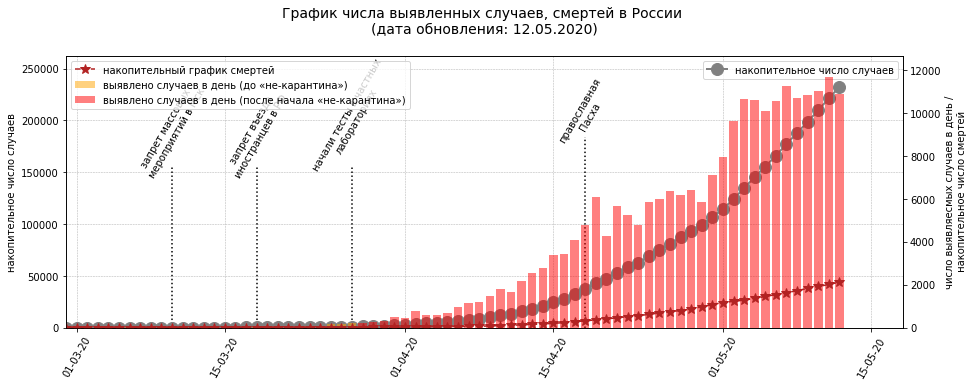

In [5]:
log = False # set True for log scale

start_date = pd.to_datetime('29-02-2020') 
    
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.xticks(rotation=60)

ax1.plot(russian_data['cases'], color='grey', marker='o', linewidth=2, markersize=12)

event_dict = {pd.to_datetime('03-10-2020'): 'запрет массовых \nмероприятий в Мск',
              pd.to_datetime('03-18-2020'): 'запрет въезда\nиностранцев в РФ',
              pd.to_datetime('03-27-2020'): 'начали тесты в частных\nлабораториях',
              pd.to_datetime('04-18-2020'): 'православная\nПасха'
             }
for date, event in event_dict.items():
    height = russian_data.loc[date, 'cases'] + russian_data['cases'].max()
    plt.text(date, 
             russian_data[russian_data.index==date]['cases_a_day'][0]+height/1.6, 
             event, 
             fontsize=10, 
             horizontalalignment='center',
             rotation=60)
    ax1.vlines(date, 0, 
               russian_data[russian_data.index==date]['cases_a_day'][0]+height/1.5, 
               linestyle=':')

if log == True: ax1.set_yscale('log')
    
ax2 = ax1.twinx()
ax2.plot(russian_data['deaths'], color='firebrick', marker='*', linestyle='--', markersize=10)

ax2.bar(x=russian_data[russian_data.index<pd.to_datetime('03-28-2020')].index, 
        height=russian_data[russian_data.index<pd.to_datetime('03-28-2020')]['cases_a_day'], 
        color='orange', alpha=0.5)

ax2.bar(x=russian_data[russian_data.index>=pd.to_datetime('03-28-2020')].index, 
        height=russian_data[russian_data.index>=pd.to_datetime('03-28-2020')]['cases_a_day'], 
        color='red', alpha=0.5)

if log == True: ax2.set_yscale('log')

title = '''График числа выявленных случаев, смертей в России {}
(дата обновления: {:%d.%m.%Y})
'''.format(''.join(['(логарифмическая шкала)' if log else '']), russian_data.index.max())

ax1.set_xlim(start_date)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
ax1.set_ylim(0, russian_data['cases'].max()+30000)
ax2.set_ylim(0, russian_data['cases_a_day'].max()+1000)
plt.title(title, fontsize=14)
ax1.legend(['накопительное число случаев'])
ax2.legend([ 'накопительный график смертей', 'выявлено случаев в день (до «не-карантина»)',
             'выявлено случаев в день (после начала «не-карантина»)'], 
               loc='upper left')#, bbox_to_anchor=(0, 0.1, 0.5, 0.8))
ax1.grid(linestyle='--', linewidth=0.5)
ax1.set_ylabel('накопительное число случаев')
ax2.set_ylabel('число выявляесмых случаев в день /\n накопительное число смертей')
plt.savefig('all_cases.png', bbox_inches="tight")
plt.show()

# Ситуация в Санкт-Петербурге

По данным [официального Штаба](https://t.me/koronavirusspb)

In [6]:
from io import BytesIO
import requests

In [7]:
google_sheet = 'https://docs.google.com/spreadsheets/d/1gHWu8YStECVLw83aiqNOn6IZfHajZgTSJYOQSrVceSU/export#gid=0&format=csv'
raw_data = requests.get(google_sheet).content
spb_df = pd.read_excel(BytesIO(raw_data), index_col=0)                     

In [8]:
spb_df = spb_df.reset_index()
spb_df['date'] = pd.to_datetime(spb_df['date'], dayfirst=True)

In [9]:
spb_df['new_death'] = spb_df['all_death'].diff()
spb_df['is_sick'] = spb_df['all_cases'] - spb_df['all_healthy']

In [10]:
spb_df = spb_df.set_index('date')

In [11]:
from scipy.stats import spearmanr

In [12]:
target = 'all_death'
for column in spb_df.select_dtypes(exclude='object').columns:
    if column != target:
        sprm = spearmanr(spb_df.dropna(subset=[column, target])[column].values, 
                         spb_df.dropna(subset=[column, target])[target].values)
        if sprm[1] <= 0.05:
            print(f'{column}: {sprm[0]}, p-value {sprm[1]}')
        

new_cases: 0.8738925775582154, p-value 3.797889066636631e-13
all_cases: 0.9973649493065532, p-value 9.100191142365712e-44
all_healthy: 0.997059943472237, p-value 6.885469745509393e-43
quarantined_for_now: -0.7351084253429778, p-value 9.858938438106326e-08
quarantined_observation: 0.7441453935109859, p-value 5.6471457106695605e-08
quarantined_selfisolated: -0.545501622522255, p-value 0.00032881920067257084
new_death: -0.4694760861708372, p-value 0.0029431200920781754
is_sick: 0.9973649493065532, p-value 9.100191142365712e-44


In [13]:
spb_df['%_of_death_from_cases'] = spb_df['all_death'] / spb_df['all_cases']
spb_df['%_of_death_from_cases'].describe()

count    39.000000
mean      0.007196
std       0.001808
min       0.004253
25%       0.006320
50%       0.007157
75%       0.007821
max       0.013274
Name: %_of_death_from_cases, dtype: float64

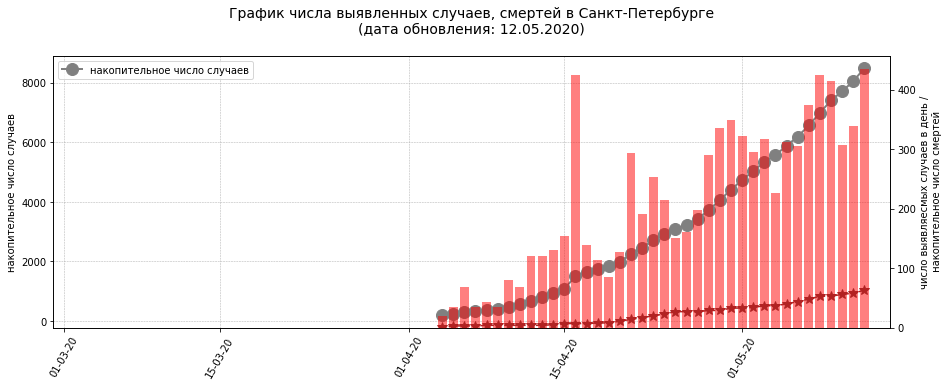

In [15]:
start_date = pd.to_datetime('29-02-2020') 
    
fig, ax1 = plt.subplots(1, 1, figsize=(15,5))
plt.xticks(rotation=60)

ax1.plot(spb_df['all_cases'], color='grey', marker='o', linewidth=2, markersize=12)

event_dict = {pd.to_datetime('03-10-2020'): 'запрет массовых \nмероприятий в Мск',
              pd.to_datetime('03-18-2020'): 'запрет въезда\nиностранцев в РФ',
              pd.to_datetime('03-27-2020'): 'начали тесты в частных\nлабораториях',
              pd.to_datetime('04-18-2020'): 'православная\nПасха'
             }
'''
for date, event in event_dict.items():
    height = russian_data.loc[date, 'cases'] + russian_data['cases'].max()
    plt.text(date, 
             russian_data[russian_data.index==date]['cases_a_day'][0]+height/1.6, 
             event, 
             fontsize=10, 
             horizontalalignment='center',
             rotation=60)
    ax1.vlines(date, 0, 
               russian_data[russian_data.index==date]['cases_a_day'][0]+height/1.5, 
               linestyle=':')'''

ax2 = ax1.twinx()
ax2.plot(spb_df['all_death'], color='firebrick', marker='*', linestyle='--', markersize=10)

ax2.bar(x=spb_df[spb_df.index<pd.to_datetime('03-28-2020')].index, 
        height=spb_df[spb_df.index<pd.to_datetime('03-28-2020')]['new_cases'], 
        color='orange', alpha=0.5)

ax2.bar(x=spb_df[spb_df.index>=pd.to_datetime('03-28-2020')].index, 
        height=spb_df[spb_df.index>=pd.to_datetime('03-28-2020')]['new_cases'], 
        color='red', alpha=0.5)

title = '''График числа выявленных случаев, смертей в Санкт-Петербурге
(дата обновления: {:%d.%m.%Y})
'''.format(spb_df.index.max())

ax1.set_xlim(start_date)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
#ax1.set_ylim(0, russian_data['cases'].max()+30000)
#ax2.set_ylim(0, russian_data['cases_a_day'].max()+1000)
plt.title(title, fontsize=14)
ax1.legend(['накопительное число случаев'])
#ax2.legend([ 'накопительный график смертей', 'выявлено случаев в день (до «не-карантина»)',
#             'выявлено случаев в день (после начала «не-карантина»)'], 
#               loc='upper left')#, bbox_to_anchor=(0, 0.1, 0.5, 0.8))
ax1.grid(linestyle='--', linewidth=0.5)
ax1.set_ylabel('накопительное число случаев')
ax2.set_ylabel('число выявляесмых случаев в день /\n накопительное число смертей')
plt.savefig('all_cases.png', bbox_inches="tight")
plt.show()